In [1]:
#testing reaction network code
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, ODETerm, Tsit5, SaveAt, Kvaerno3, Kvaerno5, PIDController
import optax  
import pickle as pkl
#from reaction_nets import rxn_net
from functools import partial
import random
#from modified_reaction_nets import random_rxn_net
from reaction_nets import random_rxn_net
from rxn_nets_old import rxn_net
import turning_points
from pybaselines import Baseline
import scipy
from scipy.signal import savgol_filter
import turning_points_memory_efficient

# Testing turning point function.

Fix initial conditions for the network.

In [2]:
n=6
m=n*(n-1)/2
seed=1
initial_conditions=jnp.log(jnp.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6]))#jnp.log(jnp.array([1/3, 1/3, 1/3]))#
all_features=jnp.linspace(-20, 20, 50) #jnp.linspace(-40, 40, 100)
t_points=jnp.linspace(0, 20, 200)
solver= Kvaerno5()
stepsize_controller=PIDController(
    rtol=1e-6,     
    atol=1e-9,   
    dtmin=1e-11,   
    dtmax=1e-1     
)
dt=0.1
max_steps=10000000
second_order_edge_idxs=None#jnp.array([[0, 1]]) #fixing the location of the second order edge 
n_second_order=1
n_inputs=1

In [3]:
rxn=random_rxn_net(n, m, seed, n_second_order, n_inputs, test=False, A=None, second_order_edge_idxs=second_order_edge_idxs, F_a_idxs=None)

In [4]:
rxn.A

Array([[0, 1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1],
       [1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 0]], dtype=int64)

In [5]:
print(rxn.F_a_idxs)

[[2 1]]


In [29]:
rxn.second_order_edges

Array([[2, 0]], dtype=int64)

In [30]:
rxn.second_order_edge_prods

Array([[0, 2]], dtype=int64)

In [31]:
rxn.second_order_edge_reactants

Array([[2, 3]], dtype=int64)

Generate 10000 random parameter sets, sampled from Unif[-10, 10].

In [8]:
params_all=[]
key = jax.random.PRNGKey(0)
subkeys = jax.random.split(key, 10000)
for subkey in subkeys:
    key1, key2, key3=jax.random.split(subkey, 3)
    B=jax.random.uniform(key1, shape=(n**2 - n), minval=-5, maxval=5) 
    F=jax.random.uniform(key2, shape=(n**2-n)//2, minval=-5, maxval=5) 
    E=jax.random.uniform(key3, shape=n, minval=-5, maxval=5)
    params_all.append([E, B, F])


In [9]:
params_file=f'data/turning_points/params_all_N0'

f=open(params_file, 'wb')
pkl.dump(params_all, f)
f.close()

In [10]:
params_file=f'data/turning_points/params_all_N0'#f'data/turning_points/params_all_N3_S0'

f=open(params_file, 'rb')
params_all=pkl.load(f)
f.close()

In [40]:
params_all[0]

[Array([-0.95767404, -4.42344102, -0.81178903,  0.23851545,  2.50671983,
         3.69578794], dtype=float64),
 Array([-3.40969749,  3.22196664,  4.36304053,  3.5653223 ,  2.12491472,
         4.63707705, -3.22645281,  0.0797938 , -4.35707727, -1.19119925,
         2.6128398 ,  0.98987994, -4.46695801, -3.54018735, -4.65952519,
         4.45343421, -1.50677345, -3.66812326, -2.08718232, -4.07374758,
         3.95711248, -0.34161081,  0.80490757,  1.79278426,  2.20678375,
         0.78646823, -0.08974455,  4.52446826,  3.83498106,  0.81352021],      dtype=float64),
 Array([ 1.71192987,  2.57670611, -4.35635206,  4.15343702,  0.10532753,
         2.59833024,  0.28830426, -2.4884716 , -3.0044889 ,  0.82084354,
        -4.54985429,  2.21907592,  3.32807009, -0.62086941,  1.23246458],      dtype=float64)]

In [43]:
sol_check=turning_points.profile(rxn, params_all[3], initial_conditions, all_features, solver, stepsize_controller, t_points, dt, max_steps)

For testing three node network.

In [14]:
'''
params_file=f'data/turning_points/params_all_N3_S0'

f=open(params_file, 'rb')
params_all=pkl.load(f)
f.close()
'''
n=3
m=n*(n-1)/2
second_order_edge_idxs=jnp.array([[0, 1]]) #fixing the location of the second order edge 
n_second_order=1
n_inputs=1
test=True
A=np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]]) #adjacency matrix
second_order_edge_idxs=np.array([[0, 1]])
F_a_idxs=np.array([[1, 2]])
E=np.array([0, 0, 0])
B=-1*jnp.log(np.array([1, 1, 10, 0.05, 0.1, 4]))
F=np.array([0, 0, 0])
test_params=(E, B, F)
seed=0
all_features=jnp.linspace(-20, 20, 50) #jnp.linspace(-40, 40, 100)
t_points=jnp.linspace(0, 20, 200)
solver= Kvaerno5()
stepsize_controller=PIDController(
    rtol=1e-6,     
    atol=1e-9,   
    dtmin=1e-11,   
    dtmax=1e-1     
)
dt=0.1
max_steps=10000000
rxn_test=random_rxn_net(n, m, seed, n_second_order, n_inputs, test, A, second_order_edge_idxs, F_a_idxs)

print(rxn_test.rxn_net_dynamics(1, jnp.log(jnp.array([0.2, 0.5, 0.3])), (E, B, F, 1,)))


[ 0.9        -2.176661    3.02776833]


In [42]:
sol_check=turning_points.profile(rxn_test, test_params, jnp.log(jnp.array([0.2, 0.5, 0.3])), all_features, solver, stepsize_controller, t_points, dt, max_steps)

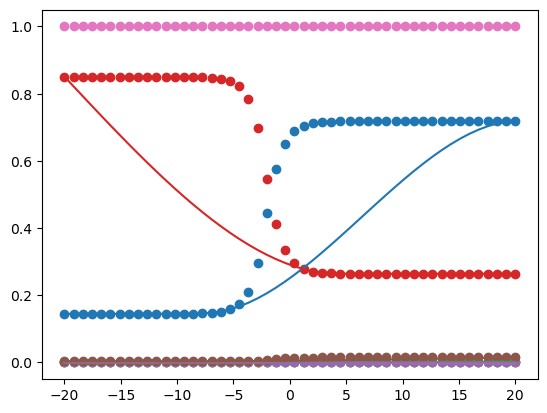

In [44]:
baseline_fitter=Baseline(x_data=all_features)
for i in range(6):
    plt.plot(all_features, baseline_fitter.arpls(sol_check.T[i], lam=0.5)[0])
    plt.scatter(all_features, sol_check.T[i])
    
plt.scatter(all_features, jnp.sum(sol_check, 1))

In [46]:
def count_turning_points_unfiltered(data, all_features, window_length=11, polyorder=2):
    if len(data) < window_length:
        window_length = max(min(len(data) - 2, 7), 3)
        window_length = window_length if window_length % 2 == 1 else window_length - 1
        polyorder = min(polyorder, window_length - 2)
    
    # Apply Savitzky-Golay filter to smooth the data
    smoothed_data = savgol_filter(data, window_length, polyorder)
    peaks, props = scipy.signal.find_peaks(data, plateau_size=1)
    troughs,props = scipy.signal.find_peaks(-data, plateau_size=1)

    # Get prominence details
    prominences, left_bases, right_bases = scipy.signal.peak_prominences(smoothed_data, peaks)
    print(f"Peak prominences: {prominences}")
    prominences, left_bases, right_bases = scipy.signal.peak_prominences(-smoothed_data, troughs)
    print(f"Peak prominences: {prominences}")
    
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    #plt.plot(all_features, data, 'b-', alpha=0.7, label='Original data')
    plt.plot(all_features, smoothed_data, 'r-', linewidth=2, label='ARPLS baseline')
    plt.scatter(all_features[peaks], smoothed_data[peaks], color='red', s=100, zorder=5, label=f'{len(peaks)} peaks')
    plt.scatter(all_features[troughs], smoothed_data[troughs], color='green', s=100, zorder=5, label=f'{len(troughs)} troughs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title('Original data vs ARPLS baseline')
    

In [79]:
def count_turning_points(data,all_features, window_length=11, polyorder=2, min_width=5):
    
    if len(data) < window_length:
        window_length = max(min(len(data) - 2, 7), 3)
    window_length = window_length if window_length % 2 == 1 else window_length - 1
    polyorder = min(polyorder, window_length - 2)
    
    # Apply Savitzky-Golay filter to smooth the data
    data = savgol_filter(data, window_length, polyorder)
    min_prominence=0.1*np.max(data)
    
    # Find peaks based on prominence criterion
    prominence_peaks, _ = scipy.signal.find_peaks(data, plateau_size=1, prominence=min_prominence)
    prominence_troughs, _ = scipy.signal.find_peaks(-data, plateau_size=1, prominence=min_prominence)

    print(prominence_peaks)
    
    # Find peaks based on width criterion
    width_peaks, _ = scipy.signal.find_peaks(data, plateau_size=1, width=min_width)
    width_troughs, _ = scipy.signal.find_peaks(-data, plateau_size=1, width=min_width)

    peaks, _ = scipy.signal.find_peaks(data, plateau_size=1)
    troughs, _ = scipy.signal.find_peaks(-data, plateau_size=1)

    print(peaks)
    print(troughs)
    
    # Combine unique peaks and troughs from both criteria
    all_peaks = np.unique(np.concatenate((prominence_peaks, width_peaks)))
    all_troughs = np.unique(np.concatenate((prominence_troughs, width_troughs)))

    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    #plt.plot(all_features, data, 'b-', alpha=0.7, label='Original data')
    plt.plot(all_features, data, 'r-', linewidth=2, label='ARPLS baseline')
    plt.scatter(all_features[all_peaks], data[all_peaks], color='red', s=100, zorder=5, label=f'{len(all_peaks)} peaks')
    plt.scatter(all_features[all_troughs], data[all_troughs], color='green', s=100, zorder=5, label=f'{len(all_troughs)} troughs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title('Original data vs ARPLS baseline')
    
    return all_peaks.shape[0] + all_troughs.shape[0]

Peak prominences: [0.]
Peak prominences: []


/var/folders/lf/7gzndb3s11g08rld41m9cfdc0000gn/T/ipykernel_9712/3333513023.py:13: PeakPropertyWarning: some peaks have a prominence of 0
  prominences, left_bases, right_bases = scipy.signal.peak_prominences(smoothed_data, peaks)


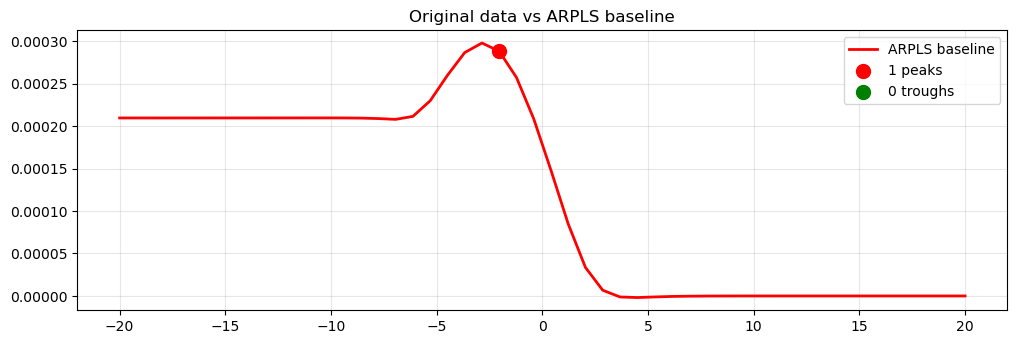

In [65]:
count_turning_points_unfiltered(sol_check.T[1], all_features)

[21]
[12 21 41]
[ 2 16 30 46]


1

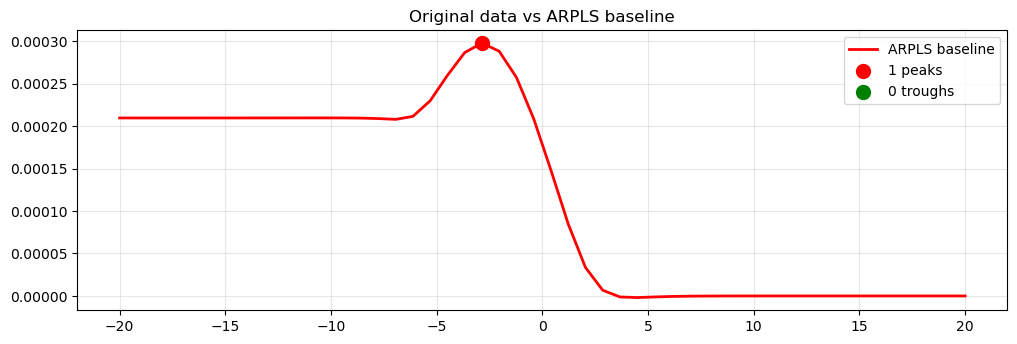

In [80]:
count_turning_points(sol_check.T[1], all_features)

In [32]:
def test_prominence_thresholds(n_tests=5):
    """
    Tests different prominence thresholds and recommends a suitable value.
    Data is restricted to 0 to 1 range for both x and y axes.
    
    Args:
        n_tests: Number of test signals to generate
    
    Returns:
        recommended_prominence: Recommended prominence threshold value
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import find_peaks, peak_prominences
    
    # Create figure for visualization
    fig, axes = plt.subplots(n_tests, 3, figsize=(18, 4*n_tests))
    
    # Test on different synthetic signals - smaller prominence values for 0-1 range
    prominence_values = np.logspace(-4, -1, 20)  # Test from 0.0001 to 0.1
    results = []
    
    for test_idx in range(n_tests):
        # Generate x values in range [0, 1]
        x = np.linspace(0, 1, 1000)
        
        # Generate different test signals, all strictly in [0, 1] range
        if test_idx == 0:
            # Sine wave (0.5 ± 0.4 to keep room for noise)
            signal = 0.5 + 0.4 * np.sin(14 * np.pi * x)  # 7 peaks
            true_peaks = 7
            noise_level = 0.02
            signal_name = "Sine wave"
        elif test_idx == 1:
            # Double sine (carefully scaled to stay in range)
            signal = 0.5 + 0.2 * np.sin(12 * np.pi * x) + 0.2 * np.sin(30 * np.pi * x)
            # Double check range
            signal = np.clip(signal, 0, 1)
            true_peaks = 15
            noise_level = 0.03
            signal_name = "Double sine"
        elif test_idx == 2:
            # Gaussian peaks
            signal = (0.8 * np.exp(-((x-0.2)/0.05)**2) + 
                     0.6 * np.exp(-((x-0.5)/0.05)**2) + 
                     0.9 * np.exp(-((x-0.8)/0.05)**2))
            # Normalize to exactly [0, 1]
            signal = signal / np.max(signal)
            true_peaks = 3
            noise_level = 0.01
            signal_name = "Gaussian peaks"
        elif test_idx == 3:
            # Damped oscillation
            signal = np.exp(-5 * (x-0.5)**2) * np.cos(30 * np.pi * x)
            # Normalize to exactly [0, 1]
            signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
            true_peaks = 5
            noise_level = 0.01
            signal_name = "Damped oscillation"
        else:
            # Polynomial with local maxima
            signal = 10 * (x * (1-x))**2 * np.sin(12 * np.pi * x)
            # Normalize to exactly [0, 1]
            signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
            true_peaks = 6
            noise_level = 0.02
            signal_name = "Oscillating polynomial"
        
        # Extra safety check - ensure signal is in [0, 1] range
        signal = np.clip(signal, 0, 1)
        
        # Add noise with buffer to avoid exceeding range
        # Scale noise to be smaller near 0 and 1 to prevent clipping
        buffer = np.minimum(signal, 1-signal)  # How far from 0 or 1
        variable_noise = noise_level * np.minimum(buffer*3, 1)  # Smaller noise near boundaries
        noisy_signal = signal + np.random.normal(0, variable_noise)
        
        # Ensure noisy signal stays in [0, 1]
        noisy_signal = np.clip(noisy_signal, 0, 1)
        
        # Test different prominence values
        peak_counts = []
        best_match_idx = 0
        best_match_diff = float('inf')
        worst_match_diff = 0
        window_length=11
        polyorder=2
        if len(noisy_signal) < window_length:
            window_length = max(min(len(noisy_signal) - 2, 7), 3)
            window_length = window_length if window_length % 2 == 1 else window_length - 1
            polyorder = min(polyorder, window_length - 2)
    
        # Apply Savitzky-Golay filter to smooth the data
        noisy_signal = savgol_filter(noisy_signal, window_length, polyorder)
        
        for i, prom in enumerate(prominence_values):
            peaks, _ = find_peaks(noisy_signal, prominence=prom)
            peak_counts.append(len(peaks))
            
            # Check how close this is to the true number of peaks
            diff = abs(len(peaks) - true_peaks)
            if diff < best_match_diff:
                best_match_diff = diff
                best_match_idx = i
            
            if diff > worst_match_diff:
                worst_match_diff = diff
                worst_match_idx = i
        
        # Save the best prominence value for this test
        results.append(prominence_values[best_match_idx])
        
        # Plot original signal
        axes[test_idx, 0].plot(x, signal, 'b-')
        axes[test_idx, 0].set_title(f"{signal_name} (true peaks: {true_peaks})")
        axes[test_idx, 0].set_xlim(0, 1)
        axes[test_idx, 0].set_ylim(0, 1)
        axes[test_idx, 0].grid(True, alpha=0.3)
        
        # Plot noisy signal with best prominence detection
        best_prom = prominence_values[best_match_idx]
        best_peaks, _ = find_peaks(noisy_signal, prominence=best_prom)
        prominences = peak_prominences(noisy_signal, best_peaks)[0]

        # Plot noisy signal with best prominence detection
        worst_prom = prominence_values[worst_match_idx]
        worst_peaks, _ = find_peaks(noisy_signal, prominence=worst_prom)
        #prominences = peak_prominences(noisy_signal, best_peaks)[0]
        
        axes[test_idx, 1].plot(x, noisy_signal, 'b-')
        axes[test_idx, 1].plot(x[worst_peaks], noisy_signal[worst_peaks], 'ro')
        axes[test_idx, 1].set_title(f"Best prom={best_prom:.6f}, peaks={len(best_peaks)}")
        axes[test_idx, 1].set_xlim(0, 1)
        axes[test_idx, 1].set_ylim(0, 1)
        axes[test_idx, 1].grid(True, alpha=0.3)
        
        # For each peak, plot its prominence
        for i, (peak_idx, prom) in enumerate(zip(best_peaks, prominences)):
            # Make sure prominence visualization doesn't go below 0
            min_y = max(0, noisy_signal[peak_idx] - prom)
            axes[test_idx, 1].vlines(x=x[peak_idx], ymin=min_y, 
                                    ymax=noisy_signal[peak_idx], color='r', linestyle='--')
        
        # Plot peak count vs prominence value
        axes[test_idx, 2].plot(prominence_values, peak_counts, 'o-')
        axes[test_idx, 2].axhline(y=true_peaks, color='r', linestyle='--', 
                                  label=f'True peaks: {true_peaks}')
        axes[test_idx, 2].axvline(x=best_prom, color='g', linestyle='--',
                                 label=f'Best prom: {best_prom:.6f}')
        axes[test_idx, 2].set_xscale('log')
        axes[test_idx, 2].set_xlabel('Prominence')
        axes[test_idx, 2].set_ylabel('Peak count')
        axes[test_idx, 2].legend()
        axes[test_idx, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Compute recommended prominence value (median of all test results)
    recommended_prominence = np.median(results)
    
    print("Tested prominence values for different signals:")
    for i, res in enumerate(results):
        print(f"Signal {i+1}: Best prominence = {res:.6f}")
    print(f"\nRECOMMENDED PROMINENCE: {recommended_prominence:.6f}")
    
    return recommended_prominence

Tested prominence values for different signals:
Signal 1: Best prominence = 0.001833
Signal 2: Best prominence = 0.033598
Signal 3: Best prominence = 0.000428
Signal 4: Best prominence = 0.001833
Signal 5: Best prominence = 0.033598

RECOMMENDED PROMINENCE: 0.001833


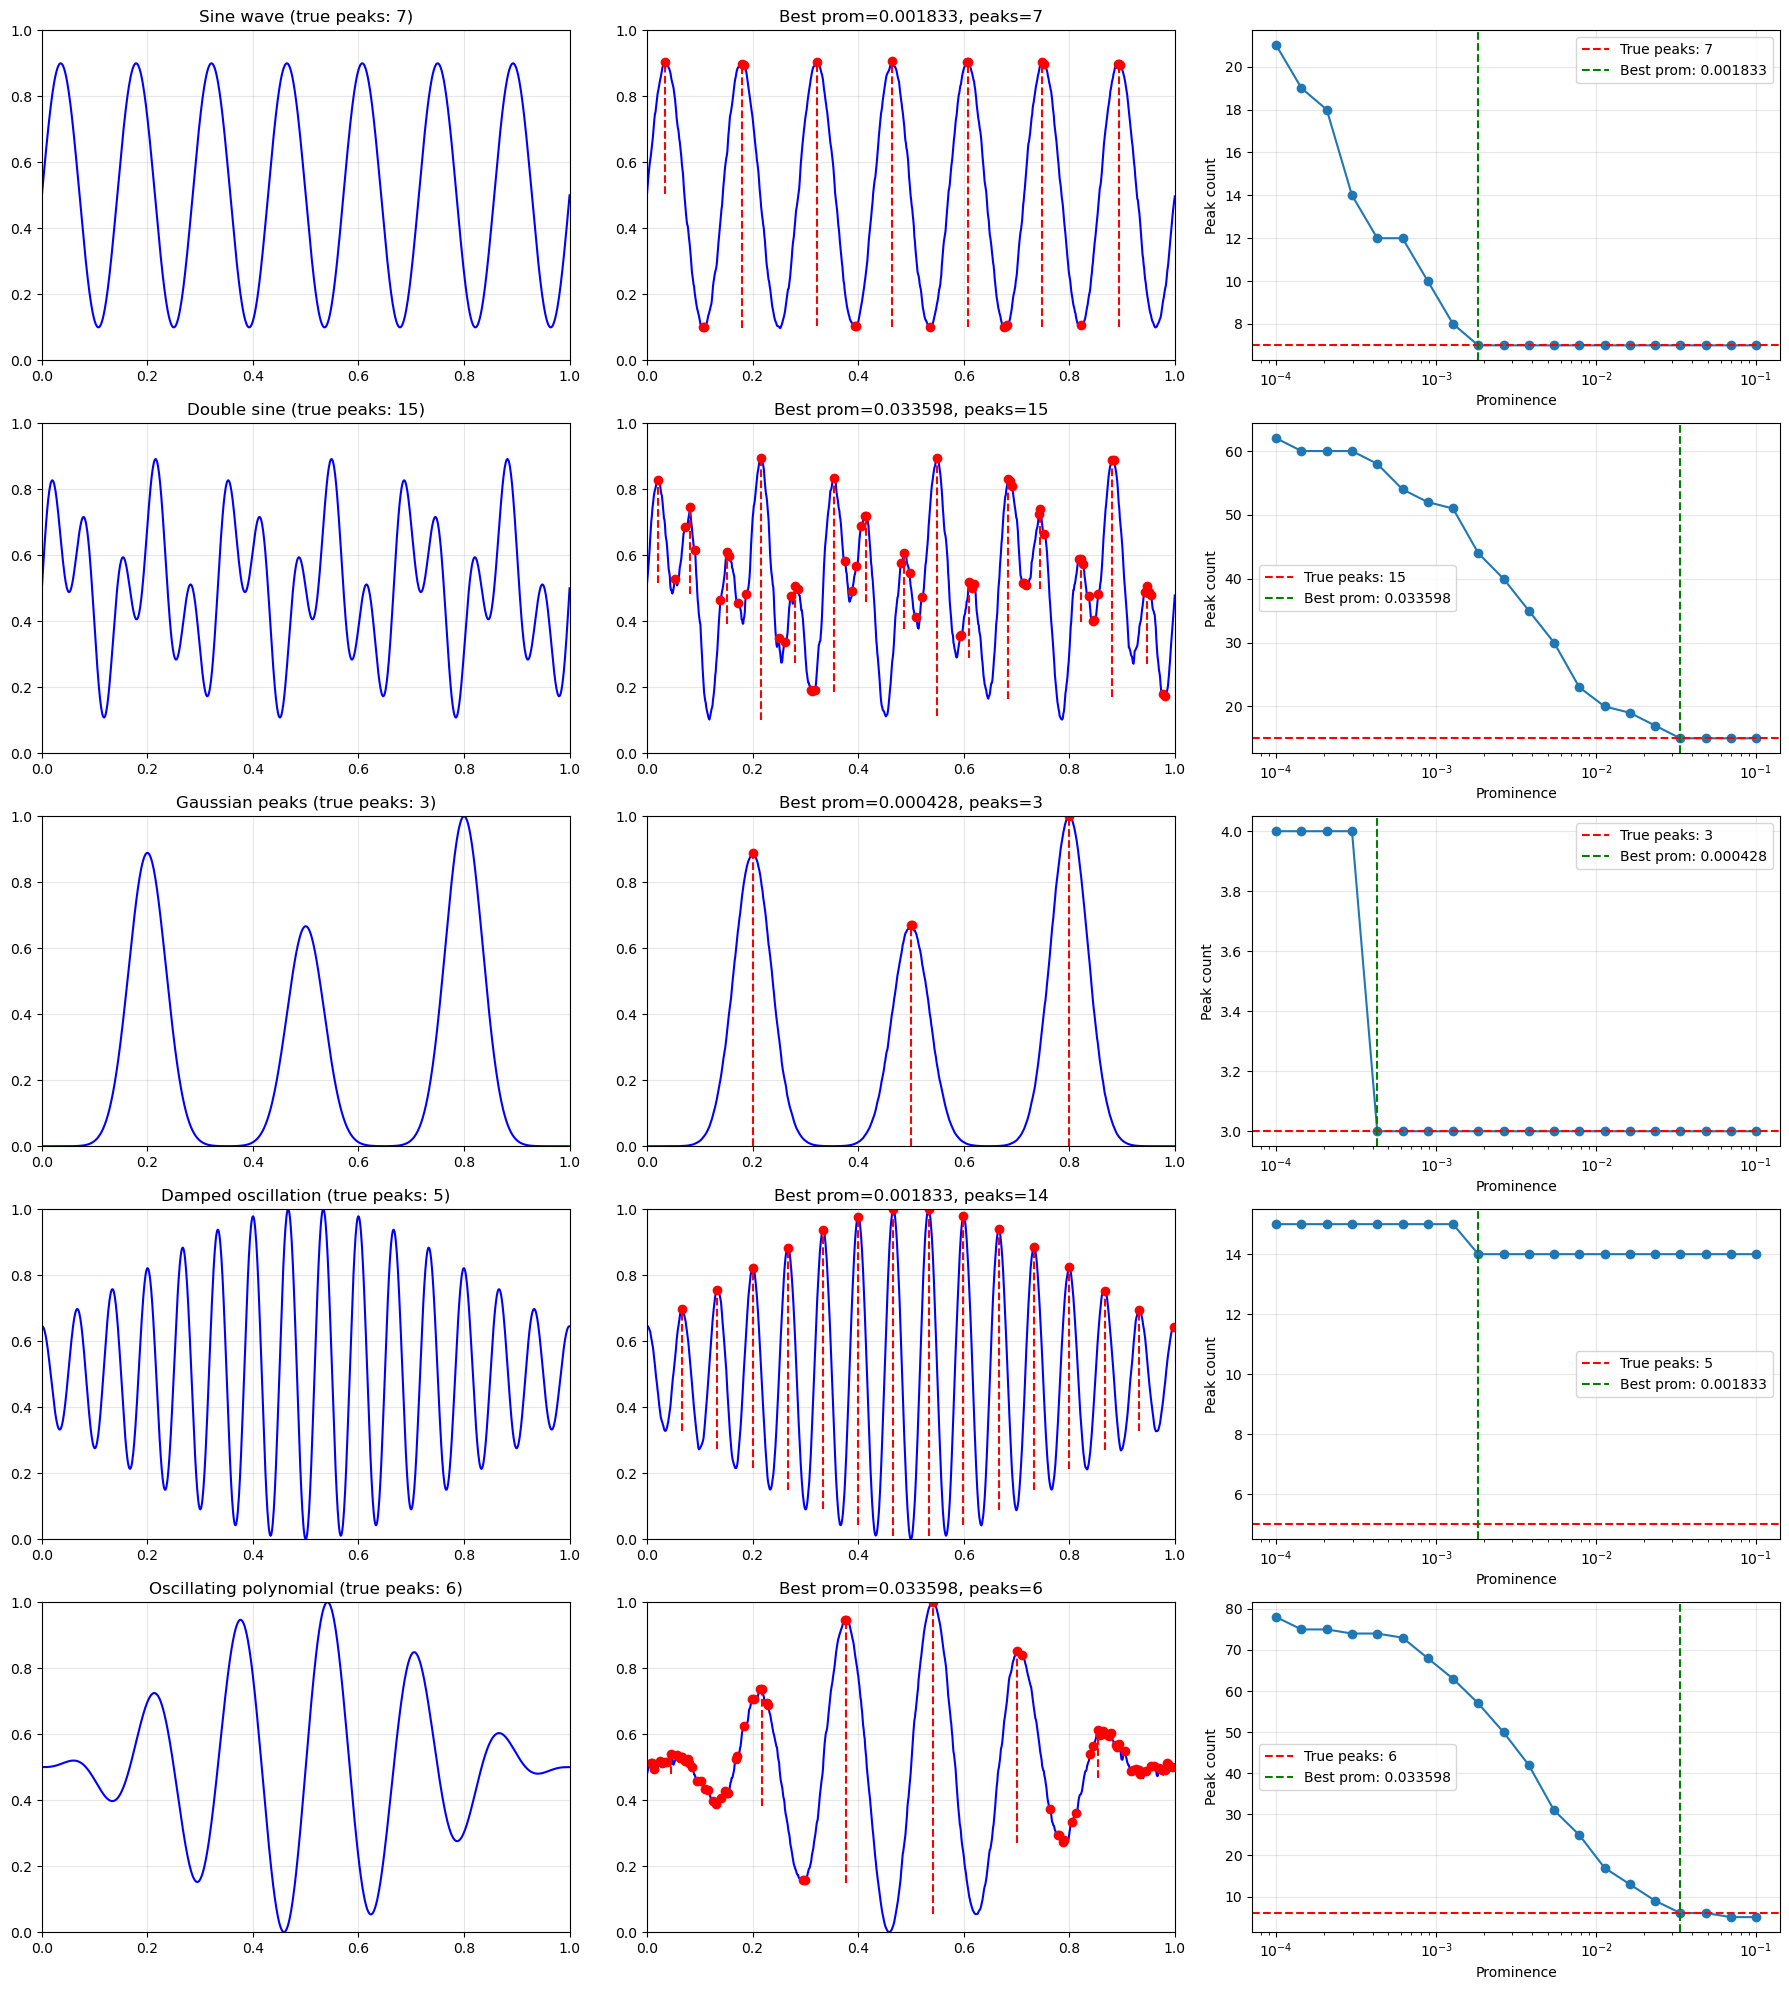

In [33]:
recommended_prominence = test_prominence_thresholds()

In [8]:
dist_tps, solns_all=turning_points.gen_profiles(params_file, n, m, seed, n_second_order, n_inputs, second_order_edge_idxs, initial_conditions, all_features, solver, stepsize_controller, t_points, dt,max_steps)

0
[Array([-0.95767404, -4.42344102, -0.81178903,  0.23851545,  2.50671983,
        3.69578794], dtype=float64), Array([-3.40969749,  3.22196664,  4.36304053,  3.5653223 ,  2.12491472,
        4.63707705, -3.22645281,  0.0797938 , -4.35707727, -1.19119925,
        2.6128398 ,  0.98987994, -4.46695801, -3.54018735, -4.65952519,
        4.45343421, -1.50677345, -3.66812326, -2.08718232, -4.07374758,
        3.95711248, -0.34161081,  0.80490757,  1.79278426,  2.20678375,
        0.78646823, -0.08974455,  4.52446826,  3.83498106,  0.81352021],      dtype=float64), Array([ 1.71192987,  2.57670611, -4.35635206,  4.15343702,  0.10532753,
        2.59833024,  0.28830426, -2.4884716 , -3.0044889 ,  0.82084354,
       -4.54985429,  2.21907592,  3.32807009, -0.62086941,  1.23246458],      dtype=float64)]
1
[Array([ 4.65325314, -2.30691003,  1.3033478 , -4.25006761,  4.49301304,
        3.24602627], dtype=float64), Array([-0.18733644, -4.3417702 ,  2.85190053, -3.18134056, -0.89042818,
       -0.74

(array([ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

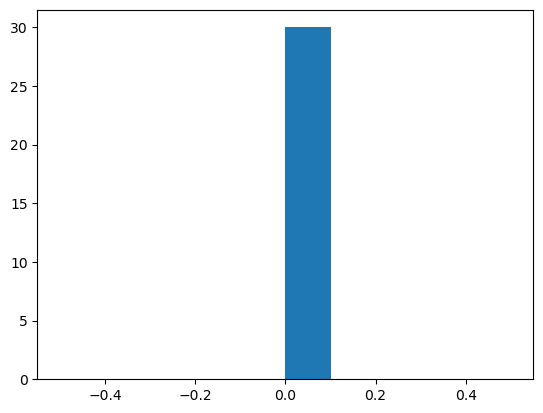

In [9]:
plt.hist(dist_tps)

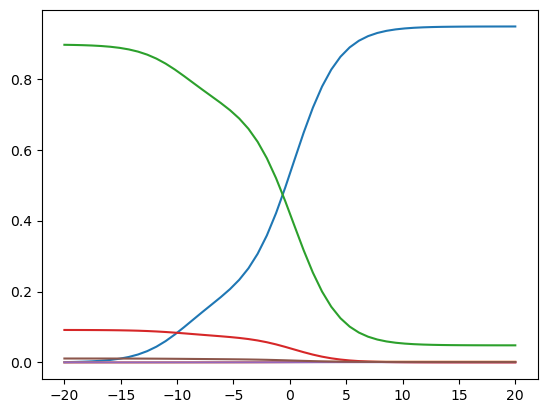

In [14]:
for i in range(n):
    plt.plot(all_features, (solns_all[4].T)[i])

# Testing turning point pipeline.

In [2]:
n=6
m=n*(n-1)//2
seeds=np.arange(1, 4001)
seeds = seeds.reshape(4, 1000)
initial_conditions=jnp.log(jnp.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6]))#jnp.log(jnp.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6]))
all_features=jnp.linspace(-20, 20, 100)
t_points=jnp.linspace(0, 20, 200)
solver= Kvaerno3()
stepsize_controller=PIDController(
    rtol=1e-6,     
    atol=1e-9,   
    dtmin=1e-11,   
    dtmax=1e-1     
    )
dt=0.1
n_second_order=2
n_inputs=1
max_steps=10000#000
params_file=f'data/turning_points/params_all_N0'
second_order_edge=jnp.array([[0, 1], [4, 1]])

In [3]:
dist, solns_all=turning_points_memory_efficient.gen_profiles_memory_efficient(params_file, n, m, seeds[n_second_order], n_second_order, n_inputs,second_order_edge, initial_conditions, all_features, solver, stepsize_controller, t_points, dt,max_steps)

TypeError: print() got an unexpected keyword argument 'x'

(36,)

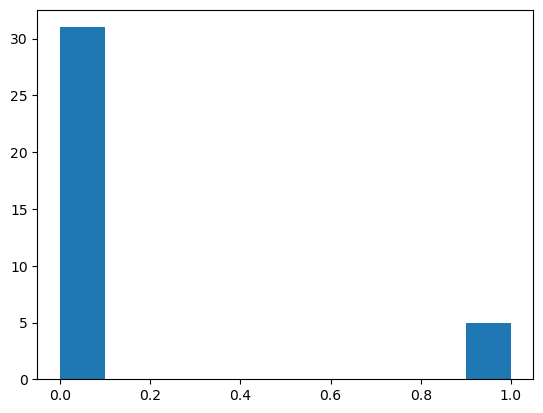

In [15]:
plt.hist(dist)
dist.shape

1

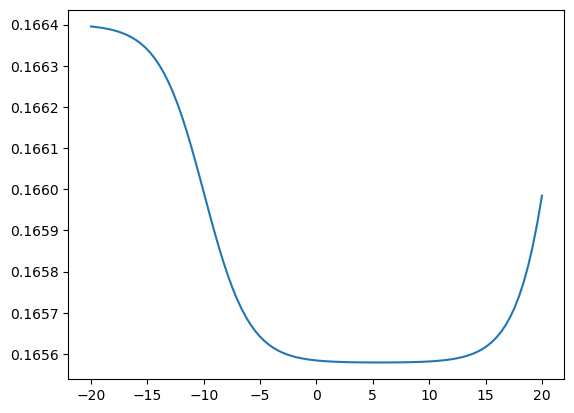

In [ ]:
plt.plot(all_features, solns_all[3].T[0])
#plt.plot(all_features, jnp.sum(jnp.log(solns_all)[3], axis=1))
turning_points_memory_efficient.count_turning_points(solns_all[3].T[0])

In [ ]:
turning_points_memory_efficient.count_turning_points(solns_all[4].T[1])

1

In [30]:
dist_file=f'data/turning_points/dist_N6_M15_S3_distributions'#f'data/turning_points/params_all_N3_S0'

f=open(dist_file, 'rb')
dist_test=pkl.load(f)
f.close()

In [31]:
prof_file=f'data/turning_points/dist_N6_M15_S3_profiles'
f=open(prof_file, 'rb')
prof_test=pkl.load(f)
f.close()

(array([0., 0., 0., 0., 0., 6., 0., 0., 0., 0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

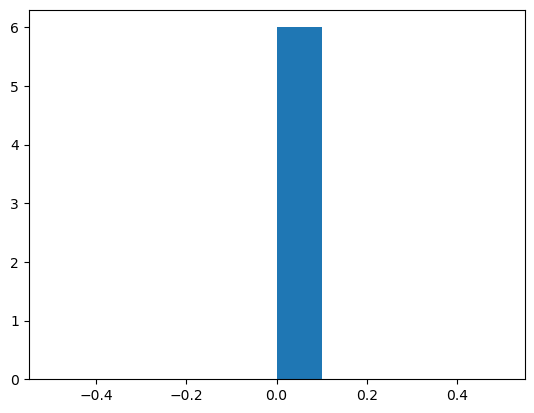

In [32]:
plt.hist(dist_test)

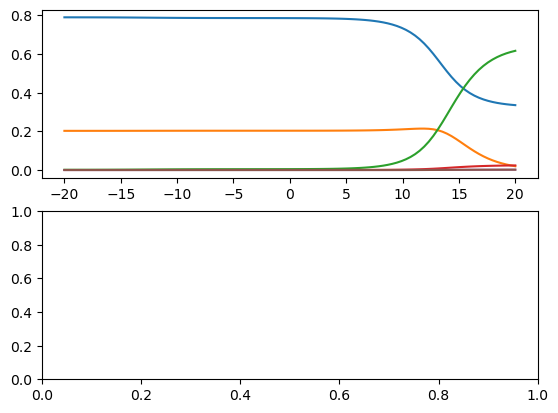

In [33]:
all_features=jnp.linspace(-20, 20, 100)
fig, axs=plt.subplots(2)
for i, prof in enumerate(prof_test):
    for species_prof in prof.T:
        axs[i].plot(all_features, species_prof)
